In [1]:
# Cell 1: Load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Time series and feature engineering
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters

# Machine learning
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from prophet import Prophet

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("All libraries loaded successfully!")
print(f"XGBoost version: {xgb.__version__}")
print(f"Pandas version: {pd.__version__}")


Importing plotly failed. Interactive plots will not work.


All libraries loaded successfully!
XGBoost version: 3.0.5
Pandas version: 2.3.3


In [7]:

# ============================================================================
# Cell 2: Load and process BRC_4_Chart69.csv
# ============================================================================

# Load the main trading data
df_chart = pd.read_csv('Data/BTC_4_Chart69.csv')

print(f"Original shape: {df_chart.shape}")
print(f"\nFirst few rows:")
print(df_chart.head())

# Create datetime column by combining Date and Time
df_chart['DateTime'] = pd.to_datetime(
    df_chart['Date'] + ' ' + df_chart['Time'], 
    format='%B %d, %Y %I:%M %p',
    errors='coerce'
)

# Sort by datetime
df_chart = df_chart.sort_values('DateTime').reset_index(drop=True)

# Handle missing values in DateTime
print(f"\nMissing DateTime values: {df_chart['DateTime'].isna().sum()}")
if df_chart['DateTime'].isna().any():
    df_chart = df_chart.dropna(subset=['DateTime'])
    print(f"Removed rows with missing DateTime. New shape: {df_chart.shape}")

# Set DateTime as index
df_chart.set_index('DateTime', inplace=True)

# Handle missing values in numeric columns
numeric_cols = df_chart.select_dtypes(include=[np.number]).columns
missing_summary = df_chart[numeric_cols].isna().sum()
missing_summary = missing_summary[missing_summary > 0]

if len(missing_summary) > 0:
    print(f"\nMissing values in numeric columns:")
    print(missing_summary)
    
    # Fill missing values with forward fill, then backward fill
    df_chart[numeric_cols] = df_chart[numeric_cols].fillna(method='ffill').fillna(method='bfill')
    print("\nMissing values handled using forward/backward fill")

# Display summary statistics
print(f"\nDataset info:")
print(f"Date range: {df_chart.index.min()} to {df_chart.index.max()}")
print(f"Total records: {len(df_chart)}")
print(f"\nKey columns statistics:")
print(df_chart[['O', 'H', 'L', 'C', 'KCD_HistoVal', 'KPO']].describe())


Original shape: (31778, 62)

First few rows:
   CHART            Date      Time      Date Close Time Close        O  \
0     69  April 11, 2025   1:42 PM             NaN        NaN  84065.0   
1     69  April 11, 2025  12:33 PM  April 11, 2025    1:42 PM  83305.0   
2     69  April 11, 2025  11:24 AM  April 11, 2025   12:33 PM  82380.0   
3     69  April 11, 2025  10:15 AM  April 11, 2025   11:24 AM  82080.0   
4     69  April 11, 2025   9:06 AM  April 11, 2025   10:15 AM  82900.0   

         H        L        C  KCD_HistoVal  ...  KCDC2C    PR_STDEV  \
0  84200.0  83720.0  84070.0         25.52  ...    4.02  672.051704   
1  84490.0  83280.0  84105.0         21.50  ...    8.02  672.068743   
2  83355.0  82225.0  83310.0         13.48  ...   -6.99  670.983921   
3  82935.0  82035.0  82430.0         20.47  ...   -3.59  669.709259   
4  83025.0  81475.0  82080.0         24.06  ...  -11.26  669.772261   

   KCD_STDEV      PR_Z     KCD_Z  PR_Z_SINCE TURN  KCD_Z SINCE TURN  \
0  16.162617

In [8]:

# ============================================================================
# Cell 3: Load and process Order_book_bias.csv
# ============================================================================

# Load order book data
df_orderbook = pd.read_csv('Data/Order_book_bias.csv')

print(f"Order Book original shape: {df_orderbook.shape}")
print(f"\nFirst few rows:")
print(df_orderbook.head())

# Create datetime column
df_orderbook['DateTime'] = pd.to_datetime(
    df_orderbook['Date'] + ' ' + df_orderbook['Time'],
    format='%d/%m/%Y %I:%M:%S %p',
    errors='coerce'
)

# Sort by datetime
df_orderbook = df_orderbook.sort_values('DateTime').reset_index(drop=True)

# Handle missing DateTime
print(f"\nMissing DateTime values: {df_orderbook['DateTime'].isna().sum()}")
if df_orderbook['DateTime'].isna().any():
    df_orderbook = df_orderbook.dropna(subset=['DateTime'])
    print(f"Removed rows with missing DateTime. New shape: {df_orderbook.shape}")

# Set DateTime as index
df_orderbook.set_index('DateTime', inplace=True)

# Clean column names (remove extra spaces)
df_orderbook.columns = df_orderbook.columns.str.strip()

# Convert numeric columns (handle commas in numbers)
numeric_cols_ob = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'Ask Volume', 'Bid Volume', 
                   'TrueHigh', 'TrueLow', 'OrderBookBias(1 period)']

for col in numeric_cols_ob:
    if col in df_orderbook.columns:
        df_orderbook[col] = pd.to_numeric(
            df_orderbook[col].astype(str).str.replace(',', ''), 
            errors='coerce'
        )

# Handle missing values
missing_ob = df_orderbook[numeric_cols_ob].isna().sum()
missing_ob = missing_ob[missing_ob > 0]

if len(missing_ob) > 0:
    print(f"\nMissing values in Order Book:")
    print(missing_ob)
    df_orderbook[numeric_cols_ob] = df_orderbook[numeric_cols_ob].fillna(method='ffill').fillna(method='bfill')

print(f"\nOrder Book info:")
print(f"Date range: {df_orderbook.index.min()} to {df_orderbook.index.max()}")
print(f"Total records: {len(df_orderbook)}")
print(f"\nOrder Book statistics:")
print(df_orderbook[['CLOSE', 'Ask Volume', 'Bid Volume', 'OrderBookBias(1 period)']].describe())

# Merge datasets on DateTime (optional - if you need combined analysis)
df_merged = df_chart.join(df_orderbook, how='left', rsuffix='_ob')
print(f"\nMerged dataset shape: {df_merged.shape}")


Order Book original shape: (5263, 11)

First few rows:
         Date         Time       OPEN        HIGH         LOW       CLOSE   \
0  02/10/2025  12:42:44 PM   3,867.30    3,867.50    3,866.50    3,867.10    
1  02/10/2025  12:41:55 PM   3,867.30    3,867.60    3,866.70    3,867.40    
2  02/10/2025  12:41:10 PM   3,867.80    3,867.80    3,867.10    3,867.40    
3  02/10/2025  12:40:09 PM   3,867.20    3,868.10    3,867.00    3,867.60    
4  02/10/2025  12:39:39 PM   3,866.20    3,867.30    3,866.10    3,867.10    

   Ask Volume  Bid Volume   TrueHigh     TrueLow  OrderBookBias(1 period)  
0          18          20   3,867.30    3,866.50                     -2.7  
1          46          33   3,867.50    3,866.70                     -5.1  
2          30          23   3,867.80    3,867.10                     -6.6  
3          40          16   3,868.10    3,867.20                     -0.5  
4          27          15   3,867.20    3,866.10                     -7.9  

Missing DateTime va

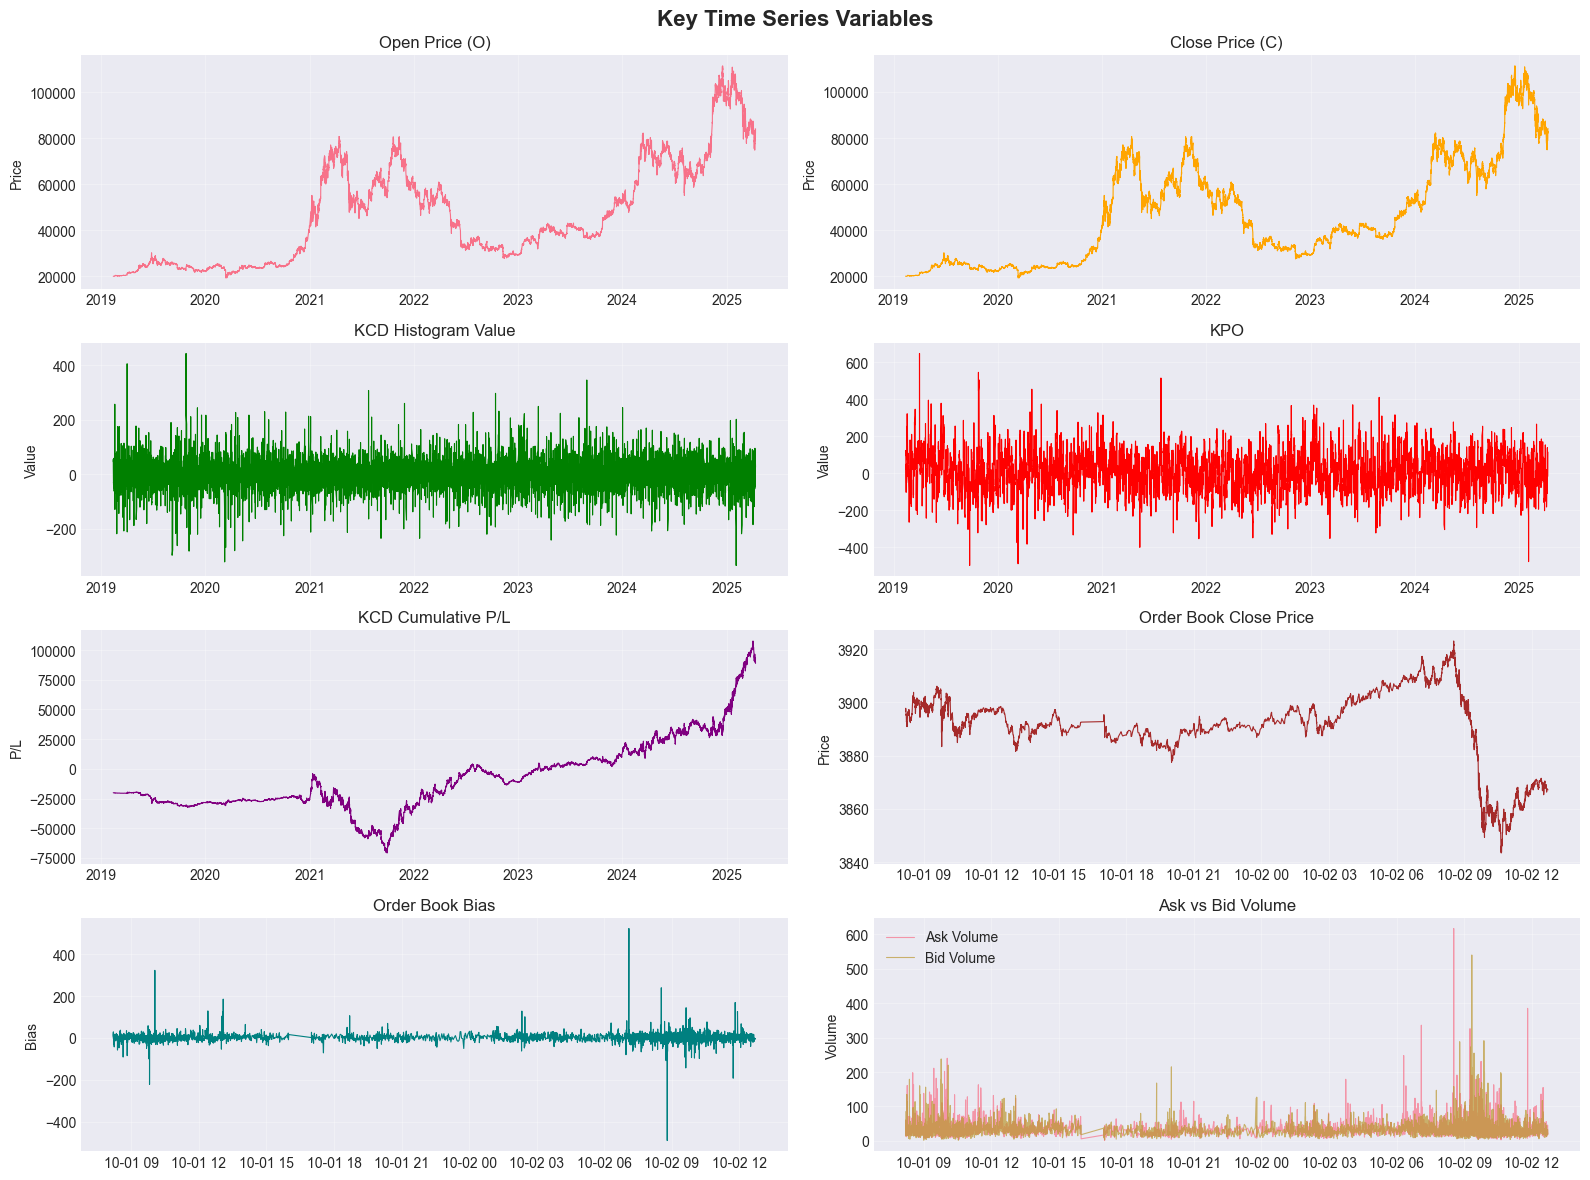


Correlation Analysis:


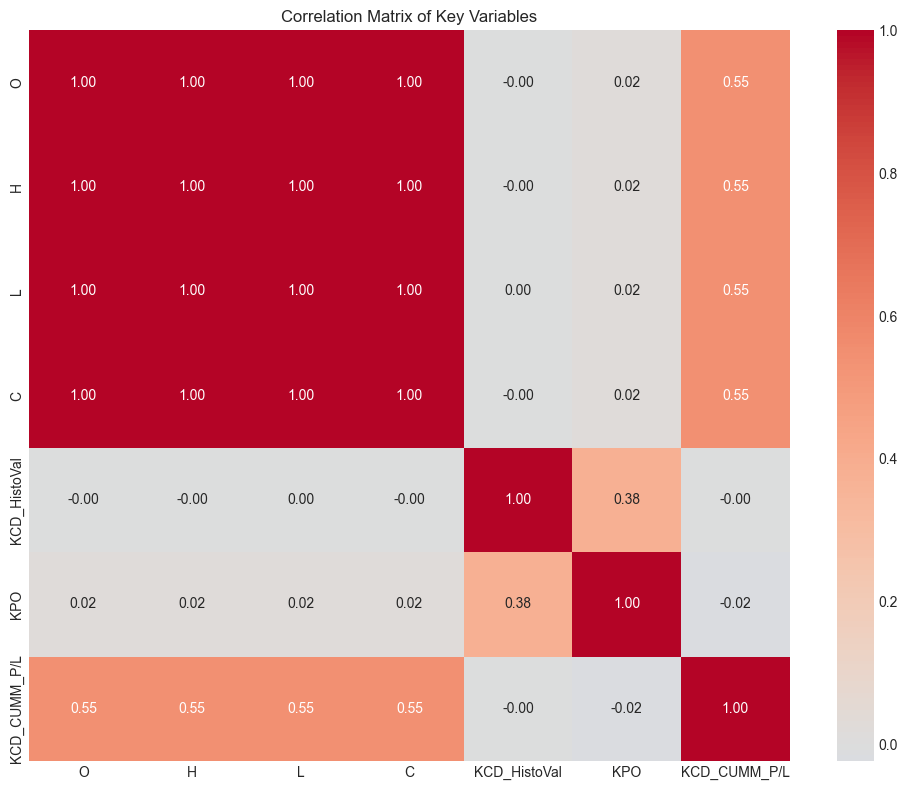

In [9]:

# ============================================================================
# Cell 4: Visualize key variables as time series
# ============================================================================

fig, axes = plt.subplots(4, 2, figsize=(16, 12))
fig.suptitle('Key Time Series Variables', fontsize=16, fontweight='bold')

# Chart data visualizations
axes[0, 0].plot(df_chart.index, df_chart['O'], linewidth=0.8)
axes[0, 0].set_title('Open Price (O)')
axes[0, 0].set_ylabel('Price')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(df_chart.index, df_chart['C'], color='orange', linewidth=0.8)
axes[0, 1].set_title('Close Price (C)')
axes[0, 1].set_ylabel('Price')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(df_chart.index, df_chart['KCD_HistoVal'], color='green', linewidth=0.8)
axes[1, 0].set_title('KCD Histogram Value')
axes[1, 0].set_ylabel('Value')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(df_chart.index, df_chart['KPO'], color='red', linewidth=0.8)
axes[1, 1].set_title('KPO')
axes[1, 1].set_ylabel('Value')
axes[1, 1].grid(True, alpha=0.3)

axes[2, 0].plot(df_chart.index, df_chart['KCD_CUMM_P/L'], color='purple', linewidth=0.8)
axes[2, 0].set_title('KCD Cumulative P/L')
axes[2, 0].set_ylabel('P/L')
axes[2, 0].grid(True, alpha=0.3)

# Order book visualizations
axes[2, 1].plot(df_orderbook.index, df_orderbook['CLOSE'], color='brown', linewidth=0.8)
axes[2, 1].set_title('Order Book Close Price')
axes[2, 1].set_ylabel('Price')
axes[2, 1].grid(True, alpha=0.3)

axes[3, 0].plot(df_orderbook.index, df_orderbook['OrderBookBias(1 period)'], 
                color='teal', linewidth=0.8)
axes[3, 0].set_title('Order Book Bias')
axes[3, 0].set_ylabel('Bias')
axes[3, 0].grid(True, alpha=0.3)

# Volume comparison
axes[3, 1].plot(df_orderbook.index, df_orderbook['Ask Volume'], 
                label='Ask Volume', alpha=0.7, linewidth=0.8)
axes[3, 1].plot(df_orderbook.index, df_orderbook['Bid Volume'], 
                label='Bid Volume', alpha=0.7, linewidth=0.8)
axes[3, 1].set_title('Ask vs Bid Volume')
axes[3, 1].set_ylabel('Volume')
axes[3, 1].legend()
axes[3, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Correlation heatmap for main features
print("\nCorrelation Analysis:")
correlation_cols = ['O', 'H', 'L', 'C', 'KCD_HistoVal', 'KPO', 'KCD_CUMM_P/L']
corr_matrix = df_chart[correlation_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Key Variables')
plt.tight_layout()
plt.show()


Total records: 31778
Training records: 25422
Test records: 6356

Training period: 2019-02-12 12:33:00 to 2024-01-18 17:00:00
Test period: 2024-01-18 17:00:00 to 2025-04-11 13:42:00

Training set shape: (25423, 62)
Test set shape: (6356, 62)


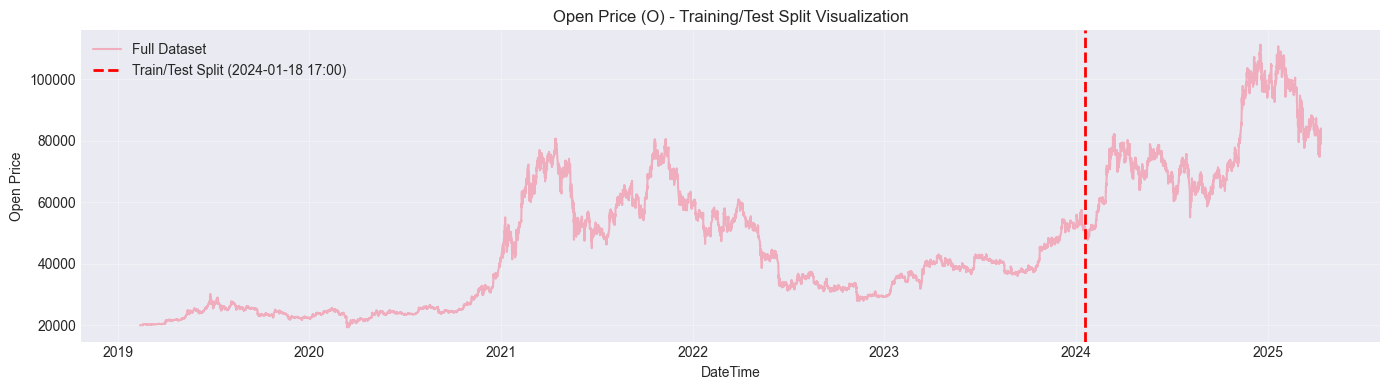

In [10]:

# ============================================================================
# Cell 5: Define cutoff points for training and test data
# ============================================================================

# Calculate split point (80-20 split)
total_records = len(df_chart)
train_size = int(total_records * 0.8)

train_cutoff_date = df_chart.index[train_size]
test_start_date = df_chart.index[train_size]

print(f"Total records: {total_records}")
print(f"Training records: {train_size}")
print(f"Test records: {total_records - train_size}")
print(f"\nTraining period: {df_chart.index.min()} to {train_cutoff_date}")
print(f"Test period: {test_start_date} to {df_chart.index.max()}")

# Split the data
df_train = df_chart.loc[:train_cutoff_date].copy()
df_test = df_chart.loc[test_start_date:].copy()

print(f"\nTraining set shape: {df_train.shape}")
print(f"Test set shape: {df_test.shape}")

# Visualize the split
plt.figure(figsize=(14, 4))
plt.plot(df_chart.index, df_chart['O'], label='Full Dataset', alpha=0.5)
plt.axvline(x=train_cutoff_date, color='red', linestyle='--', linewidth=2, 
            label=f'Train/Test Split ({train_cutoff_date.strftime("%Y-%m-%d %H:%M")})')
plt.title('Open Price (O) - Training/Test Split Visualization')
plt.xlabel('DateTime')
plt.ylabel('Open Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [14]:
# ============================================================================
# Cell 6: Feature engineering with tsfresh and model training
# ============================================================================

# Prepare data for tsfresh
# We need to create a dataframe with id, time, and value columns
print("Extracting features using tsfresh (this may take a few minutes)...")

# Prepare training data for tsfresh
train_ts = df_train.reset_index()
train_ts['id'] = 1  # Single time series
train_ts['time'] = range(len(train_ts))

# Use MinimalFCParameters for faster extraction (fewer features)
# Alternatively use EfficientFCParameters for a balance
from tsfresh.feature_extraction import EfficientFCParameters, EfficientFCParameters

# Option 1: Minimal (fastest, ~20 features)
fc_parameters = EfficientFCParameters()

# Option 2: Efficient (medium speed, ~100 features) - uncomment to use
# fc_parameters = EfficientFCParameters()

# Option 3: Custom selection (only specific features) - uncomment to use
# from tsfresh.feature_extraction.settings import from_columns
# fc_parameters = {
#     "length": None,
#     "mean": None,
#     "median": None,
#     "standard_deviation": None,
#     "variance": None,
#     "minimum": None,
#     "maximum": None,
#     "skewness": None,
#     "kurtosis": None,
#     "absolute_sum_of_changes": None,
# }

# Extract features with multiprocessing for speed
features_train = extract_features(
    train_ts[['id', 'time', 'O']], 
    column_id='id', 
    column_sort='time',
    column_value='O',
    default_fc_parameters=fc_parameters,
    disable_progressbar=False,
    n_jobs=4  # Use 4 CPU cores (adjust based on your system)
)

# Impute NaN values
features_train = impute(features_train)

print(f"Extracted {len(features_train.columns)} features from tsfresh")

# Add additional manual features
df_train['O_lag1'] = df_train['O'].shift(1)
df_train['O_lag2'] = df_train['O'].shift(2)
df_train['O_lag3'] = df_train['O'].shift(3)
df_train['O_rolling_mean_5'] = df_train['O'].rolling(window=5).mean()
df_train['O_rolling_std_5'] = df_train['O'].rolling(window=5).std()
df_train['O_rolling_mean_10'] = df_train['O'].rolling(window=10).mean()
df_train['O_diff'] = df_train['O'].diff()
df_train['hour'] = df_train.index.hour
df_train['day_of_week'] = df_train.index.dayofweek

# Remove NaN rows created by lag features
df_train_clean = df_train.dropna()

# Prepare features for XGBoost
manual_features = ['O_lag1', 'O_lag2', 'O_lag3', 'O_rolling_mean_5', 
                   'O_rolling_std_5', 'O_rolling_mean_10', 'O_diff', 
                   'hour', 'day_of_week']

# Combine tsfresh features with manual features
X_train = df_train_clean[manual_features].copy()

# Add tsfresh features (use all available features from Minimal/Efficient parameters)
# Since we're using fewer features now, we can include them all
for col in features_train.columns:
    X_train[col] = features_train[col].values[0]

y_train = df_train_clean['O'].values

print(f"\nFeature matrix shape: {X_train.shape}")
print(f"Target variable shape: {y_train.shape}")

# Train XGBoost model
print("\nTraining XGBoost model...")
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    objective='reg:squarederror'
)

xgb_model.fit(X_train, y_train)
train_pred_xgb = xgb_model.predict(X_train)

# Prepare test data with same features
df_test['O_lag1'] = df_test['O'].shift(1)
df_test['O_lag2'] = df_test['O'].shift(2)
df_test['O_lag3'] = df_test['O'].shift(3)
df_test['O_rolling_mean_5'] = df_test['O'].rolling(window=5).mean()
df_test['O_rolling_std_5'] = df_test['O'].rolling(window=5).std()
df_test['O_rolling_mean_10'] = df_test['O'].rolling(window=10).mean()
df_test['O_diff'] = df_test['O'].diff()
df_test['hour'] = df_test.index.hour
df_test['day_of_week'] = df_test.index.dayofweek

df_test_clean = df_test.dropna()

X_test = df_test_clean[manual_features].copy()
for col in features_train.columns:
    X_test[col] = features_train[col].values[0]

y_test = df_test_clean['O'].values
test_pred_xgb = xgb_model.predict(X_test)

# Train Prophet model
print("\nTraining Prophet model...")
prophet_train = df_train.reset_index()[['DateTime', 'O']].copy()
prophet_train.columns = ['ds', 'y']

prophet_model = Prophet(
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10.0,
    daily_seasonality=True,
    weekly_seasonality=True
)
prophet_model.fit(prophet_train)

# Make predictions
future_train = prophet_model.make_future_dataframe(periods=0, freq='T')
forecast_train = prophet_model.predict(future_train)
train_pred_prophet = forecast_train['yhat'].values

future_test = pd.DataFrame({'ds': df_test_clean.index})
forecast_test = prophet_model.predict(future_test)
test_pred_prophet = forecast_test['yhat'].values

print("\nModels trained successfully!")


Extracting features using tsfresh (this may take a few minutes)...


Feature Extraction: 100%|██████████| 1/1 [00:03<00:00,  3.81s/it]


Extracted 777 features from tsfresh

Feature matrix shape: (25414, 786)
Target variable shape: (25414,)

Training XGBoost model...

Training Prophet model...


21:20:00 - cmdstanpy - INFO - Chain [1] start processing
21:20:12 - cmdstanpy - INFO - Chain [1] done processing



Models trained successfully!



XGBoost - Training Metrics:
  MAE:  60.85
  RMSE: 97.85
  R²:   1.0000
  MAPE: 0.15%

XGBoost - Test Metrics:
  MAE:  5529.96
  RMSE: 10438.37
  R²:   0.4964
  MAPE: 5.63%

Prophet - Training Metrics:
  MAE:  1540.70
  RMSE: 2132.19
  R²:   0.9809
  MAPE: 3.91%

Prophet - Test Metrics:
  MAE:  11477.82
  RMSE: 14659.85
  R²:   0.0066
  MAPE: 13.58%


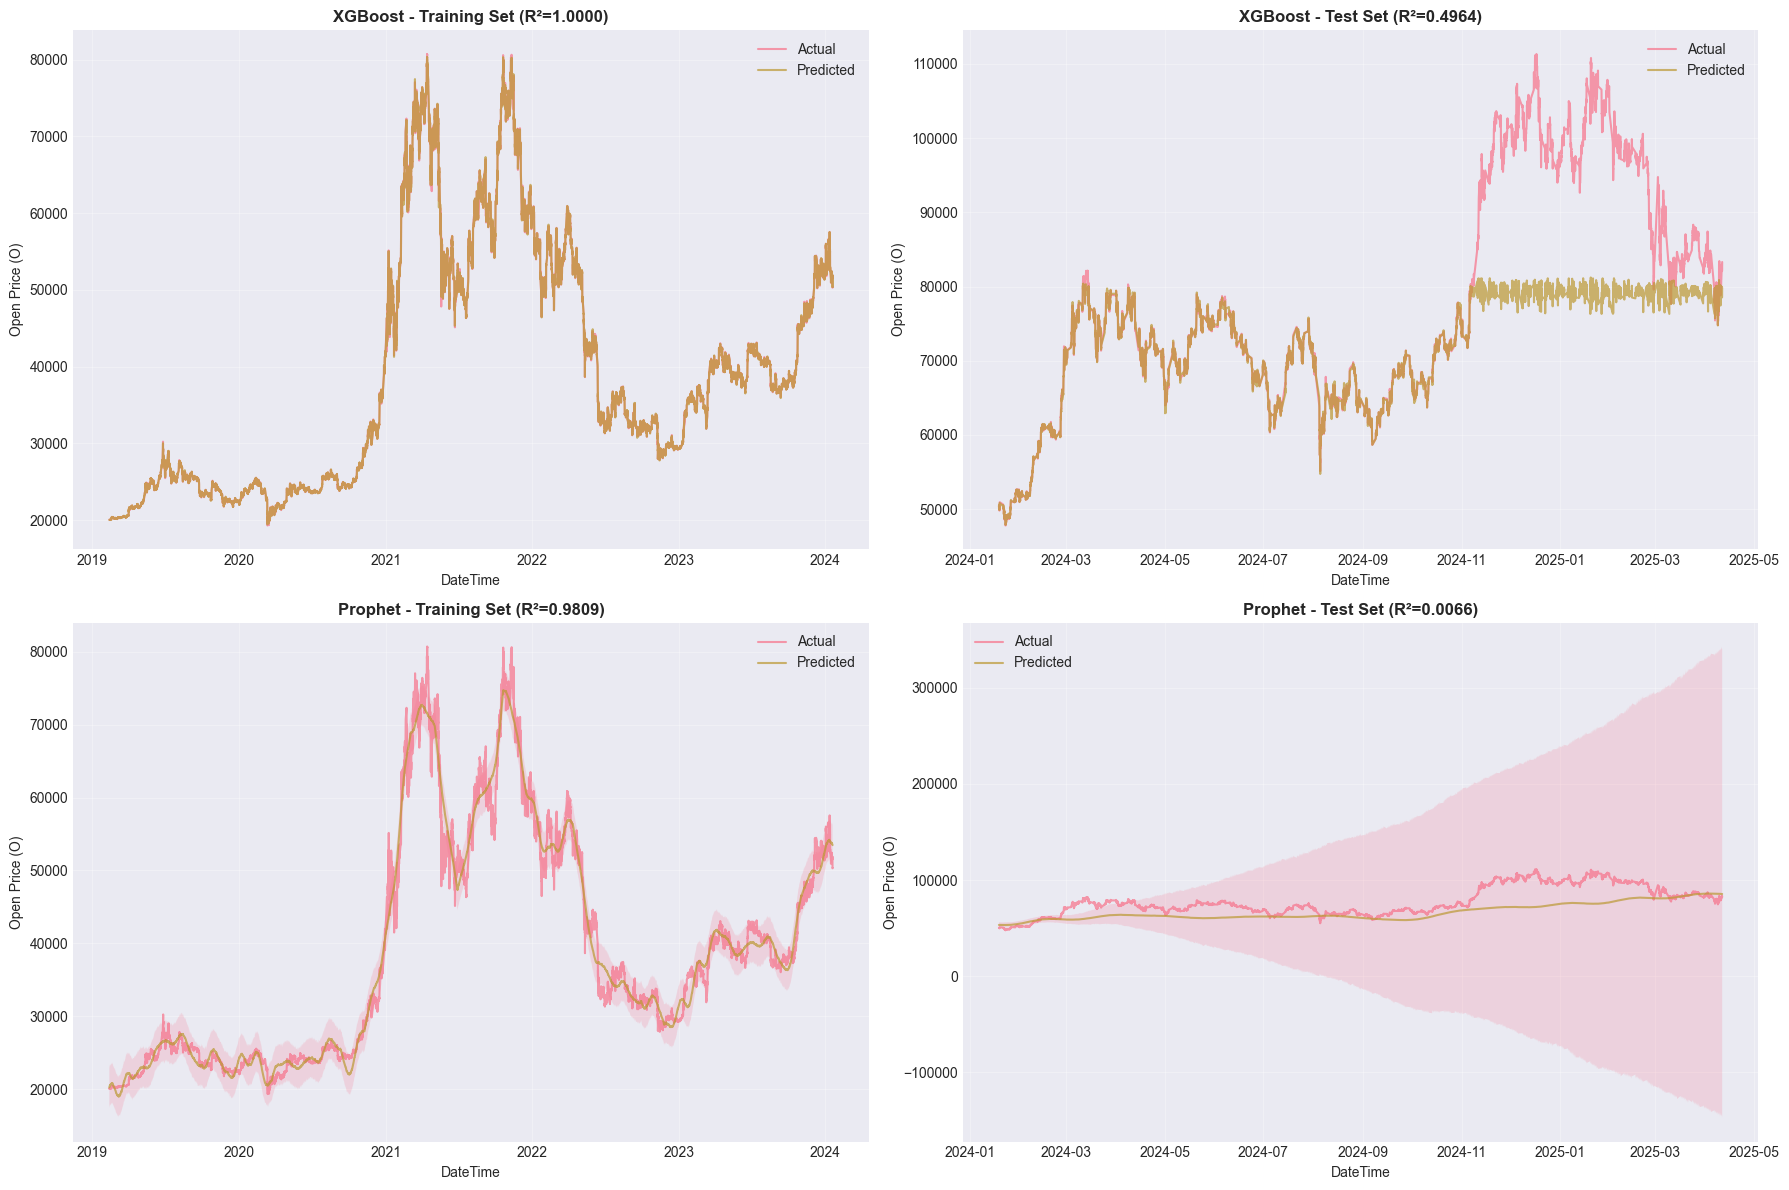

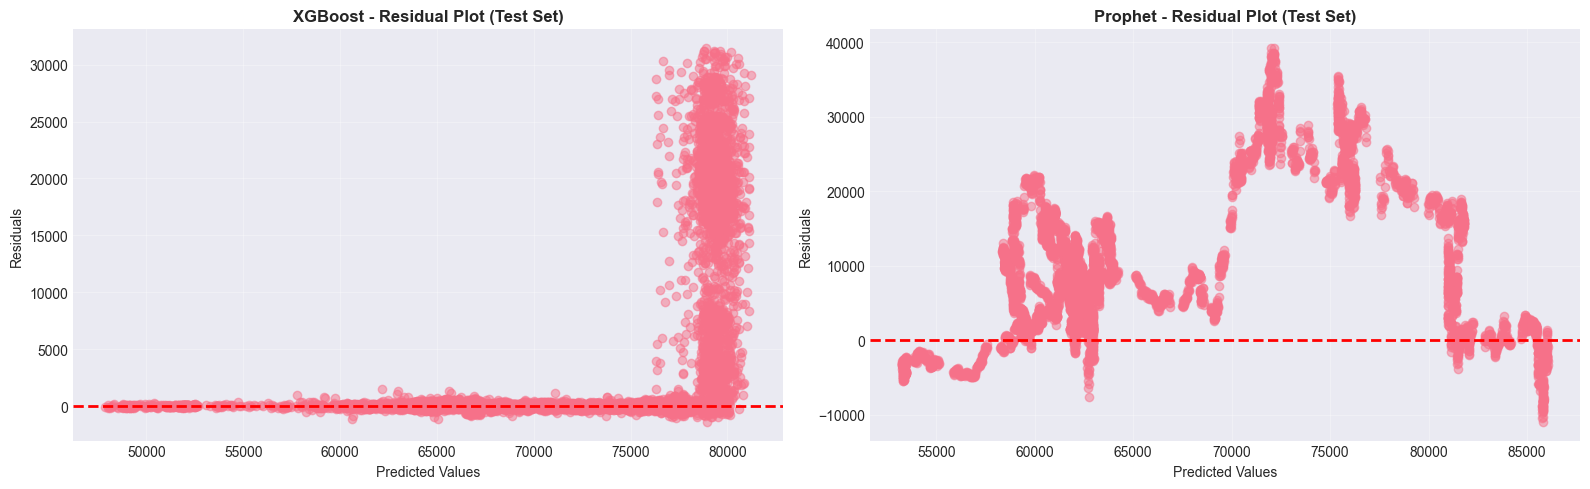

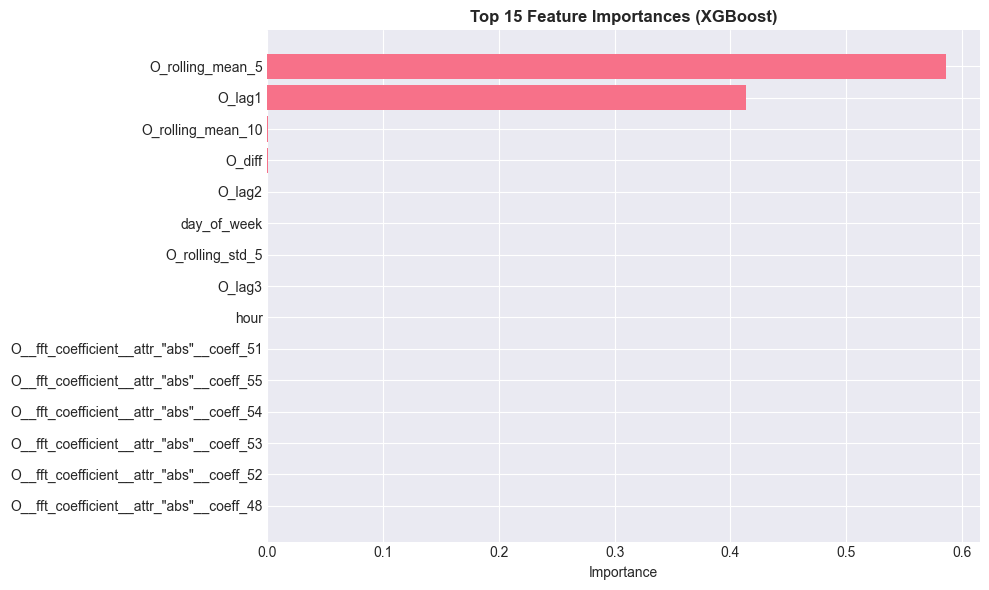


FINAL METRICS SUMMARY
  Model  Dataset          MAE         RMSE       R²      MAPE
XGBoost Training    60.846423    97.852323 0.999960  0.146085
XGBoost     Test  5529.957644 10438.371601 0.496371  5.634049
Prophet Training  1540.703178  2132.186218 0.980896  3.907672
Prophet     Test 11477.816031 14659.851346 0.006644 13.577624


In [15]:

# ============================================================================
# Cell 7: Visualize predictions and report metrics
# ============================================================================

# Calculate metrics
def calculate_metrics(y_true, y_pred, model_name, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f"\n{model_name} - {dataset_name} Metrics:")
    print(f"  MAE:  {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²:   {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'MAPE': mape}

# Calculate all metrics
metrics_xgb_train = calculate_metrics(y_train, train_pred_xgb, "XGBoost", "Training")
metrics_xgb_test = calculate_metrics(y_test, test_pred_xgb, "XGBoost", "Test")
metrics_prophet_train = calculate_metrics(prophet_train['y'].values, train_pred_prophet, "Prophet", "Training")
metrics_prophet_test = calculate_metrics(y_test, test_pred_prophet, "Prophet", "Test")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# XGBoost - Training
axes[0, 0].plot(df_train_clean.index, y_train, label='Actual', alpha=0.7, linewidth=1.5)
axes[0, 0].plot(df_train_clean.index, train_pred_xgb, label='Predicted', alpha=0.7, linewidth=1.5)
axes[0, 0].set_title(f'XGBoost - Training Set (R²={metrics_xgb_train["R2"]:.4f})', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('DateTime')
axes[0, 0].set_ylabel('Open Price (O)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# XGBoost - Test
axes[0, 1].plot(df_test_clean.index, y_test, label='Actual', alpha=0.7, linewidth=1.5)
axes[0, 1].plot(df_test_clean.index, test_pred_xgb, label='Predicted', alpha=0.7, linewidth=1.5)
axes[0, 1].set_title(f'XGBoost - Test Set (R²={metrics_xgb_test["R2"]:.4f})', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('DateTime')
axes[0, 1].set_ylabel('Open Price (O)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Prophet - Training
axes[1, 0].plot(prophet_train['ds'], prophet_train['y'], label='Actual', alpha=0.7, linewidth=1.5)
axes[1, 0].plot(forecast_train['ds'], forecast_train['yhat'], label='Predicted', alpha=0.7, linewidth=1.5)
axes[1, 0].fill_between(forecast_train['ds'], forecast_train['yhat_lower'], 
                        forecast_train['yhat_upper'], alpha=0.2)
axes[1, 0].set_title(f'Prophet - Training Set (R²={metrics_prophet_train["R2"]:.4f})', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('DateTime')
axes[1, 0].set_ylabel('Open Price (O)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Prophet - Test
axes[1, 1].plot(df_test_clean.index, y_test, label='Actual', alpha=0.7, linewidth=1.5)
axes[1, 1].plot(forecast_test['ds'], forecast_test['yhat'], label='Predicted', alpha=0.7, linewidth=1.5)
axes[1, 1].fill_between(forecast_test['ds'], forecast_test['yhat_lower'], 
                        forecast_test['yhat_upper'], alpha=0.2)
axes[1, 1].set_title(f'Prophet - Test Set (R²={metrics_prophet_test["R2"]:.4f})', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('DateTime')
axes[1, 1].set_ylabel('Open Price (O)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Residual plots
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# XGBoost residuals
residuals_xgb_test = y_test - test_pred_xgb
axes[0].scatter(test_pred_xgb, residuals_xgb_test, alpha=0.5)
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0].set_title('XGBoost - Residual Plot (Test Set)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicted Values')
axes[0].set_ylabel('Residuals')
axes[0].grid(True, alpha=0.3)

# Prophet residuals
residuals_prophet_test = y_test - test_pred_prophet
axes[1].scatter(test_pred_prophet, residuals_prophet_test, alpha=0.5)
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1].set_title('Prophet - Residual Plot (Test Set)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Residuals')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Feature importance (XGBoost)
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances (XGBoost)', fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Summary metrics table
metrics_summary = pd.DataFrame({
    'Model': ['XGBoost', 'XGBoost', 'Prophet', 'Prophet'],
    'Dataset': ['Training', 'Test', 'Training', 'Test'],
    'MAE': [metrics_xgb_train['MAE'], metrics_xgb_test['MAE'], 
            metrics_prophet_train['MAE'], metrics_prophet_test['MAE']],
    'RMSE': [metrics_xgb_train['RMSE'], metrics_xgb_test['RMSE'], 
             metrics_prophet_train['RMSE'], metrics_prophet_test['RMSE']],
    'R²': [metrics_xgb_train['R2'], metrics_xgb_test['R2'], 
           metrics_prophet_train['R2'], metrics_prophet_test['R2']],
    'MAPE': [metrics_xgb_train['MAPE'], metrics_xgb_test['MAPE'], 
             metrics_prophet_train['MAPE'], metrics_prophet_test['MAPE']]
})

print("\n" + "="*80)
print("FINAL METRICS SUMMARY")
print("="*80)
print(metrics_summary.to_string(index=False))